---
---
# <font color='#f78fb3'> **1 Setup**<br> </font> 

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import sklearn.decomposition as dec
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Common imports
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
# import seaborn to make nice plots
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

---
---
# <font color='#f78fb3'> **1 AutoEncoder**<br> </font> 

### <font color='#f78fb3'> <font color='#f9ca24'>**1.1 MNISTS**<br> </font>  

In [3]:
from sklearn.preprocessing import MinMaxScaler

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.reshape(-1,784)
X_test = X_test.reshape(-1,784)

scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))

#X_train_full = X_train_full.astype(np.float32) / 255
#X_test = X_test.astype(np.float32) / 255

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train.shape, X_valid.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [5]:
# Deep Learnign libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.display import display, Math, Latex
import datetime

In [6]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each layer []
input_dim = X_train.shape[1]
encoding1_dim = 350
encoding2_dim = 150
latent_dim = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
encoder = Dense(int(latent_dim), activation='relu')(encoder)
decoder = Dense(int(encoding2_dim), activation='relu')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 350)               274750    
                                                                 
 dense_1 (Dense)             (None, 150)               52650     
                                                                 
 dense_2 (Dense)             (None, 20)                3020      
                                                                 
 dense_3 (Dense)             (None, 150)               3150      
                                                                 
 dense_4 (Dense)             (None, 350)               52850     
                                                                 
 dense_5 (Dense)             (None, 784)               275184

In [7]:
# this models maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

In [8]:
nb_epoch = 20
batch_size = 10000
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_data=(X_valid, X_valid),
                          #verbose=1,
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/20
1719/1719 [==============================] - 8s 3ms/step - loss: 0.0261 - val_loss: 0.0197
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0184 - val_loss: 0.0176
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 7/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 8/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0146 - val_loss: 0.0147
Epoch 9/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 10/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.013

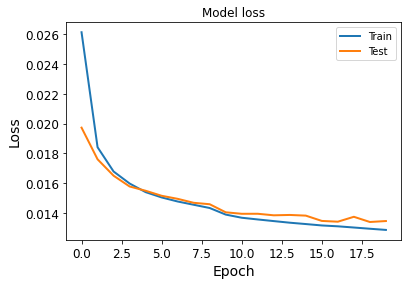

In [9]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_valid_ae = encoder_layer.predict(X_valid)
X_valid_ae_tsne = tsne.fit_transform(X_valid_ae)

tsne = TSNE()
X_valid_tsne = tsne.fit_transform(X_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


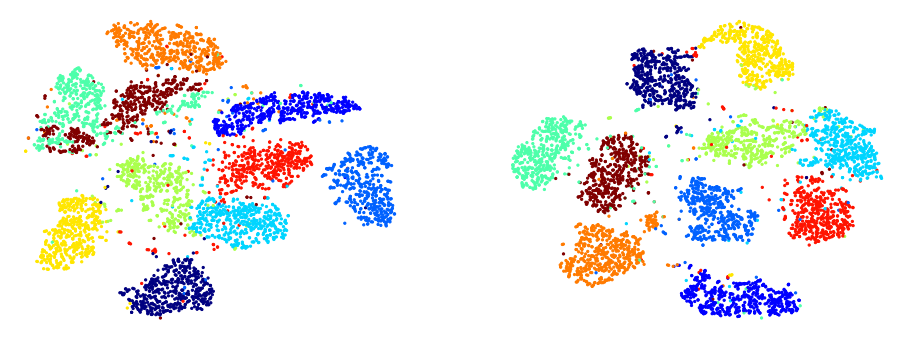

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_tsne[:, 0], X_valid_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
plt.show()

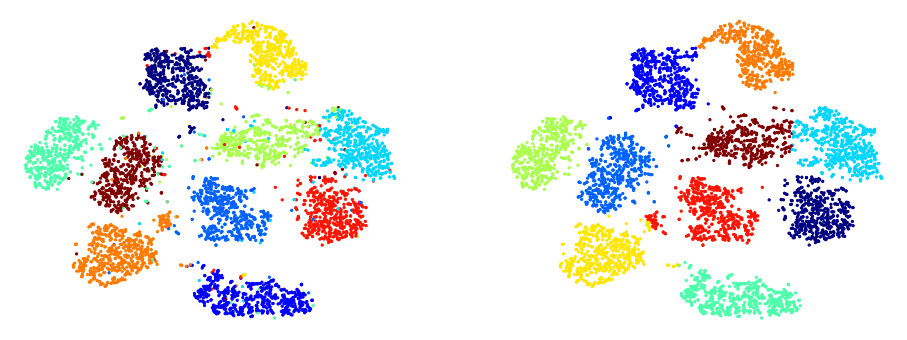

In [ ]:
cluster_df = pd.DataFrame(y_valid, columns=['Label'])
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=9)
kmeans.fit(X_valid_ae_tsne)
cluster_labels = kmeans.labels_
cluster_df['KMeans_cluster'] = cluster_labels

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=cluster_df ['Label'], s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=cluster_df ['KMeans_cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

---
---
# <font color='#f78fb3'> **2. Variational AutoEncoder**<br> </font> 

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
        
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 20

inputs = keras.layers.Input(shape=[784])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(300, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(300, activation="selu")(x)
x = keras.layers.Dense(784, activation="selu")(x)
outputs = keras.layers.Reshape([784])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="adam")
history = variational_ae.fit(X_train, X_train, epochs=20, #batch_size=5000,
                             validation_data=(X_valid, X_valid))
df_history = pd.DataFrame(history.history)

Epoch 1/20
1719/1719 [==============================] - 7s 3ms/step - loss: 0.0562 - val_loss: 0.0513
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0501 - val_loss: 0.0486
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0482 - val_loss: 0.0475
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0473 - val_loss: 0.0466
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0466 - val_loss: 0.0462
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0462 - val_loss: 0.0458
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0459 - val_loss: 0.0455
Epoch 8/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0457 - val_loss: 0.0451
Epoch 9/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0454 - val_loss: 0.0449
Epoch 10/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.045

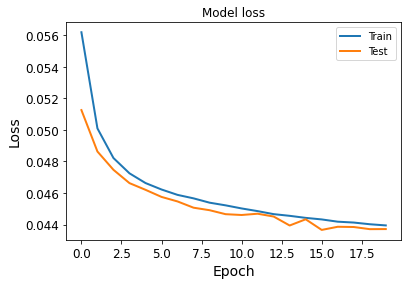

In [ ]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_valid_vae = variational_encoder.predict(X_valid)[0]
X_valid_vae_tsne = tsne.fit_transform(X_valid_vae)

tsne = TSNE()
#X_valid_tsne = tsne.fit_transform(X_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


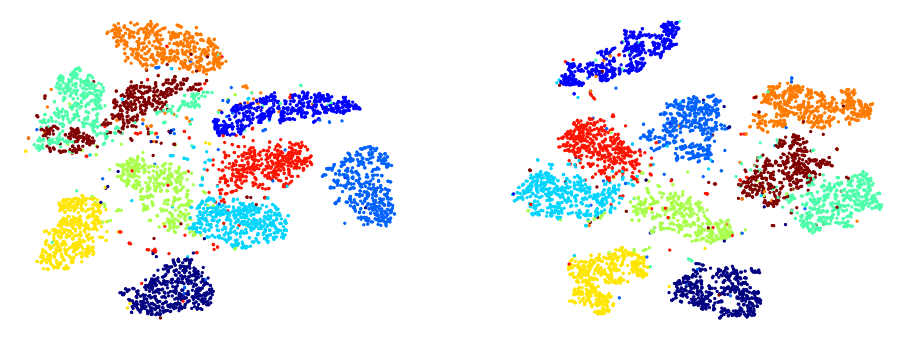

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_tsne[:, 0], X_valid_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
plt.show()

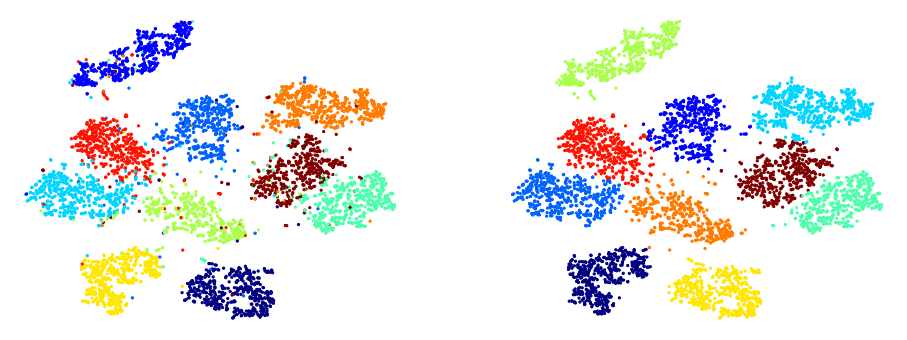

In [ ]:
cluster_df = pd.DataFrame(y_valid, columns=['Label'])
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=9)
kmeans.fit(X_valid_vae_tsne)
cluster_labels = kmeans.labels_
cluster_df['KMeans_cluster'] = cluster_labels

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=cluster_df ['Label'], s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=cluster_df ['KMeans_cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()